In [194]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
%matplotlib ipympl

In [195]:
def interp_coordinates_from_optical_path_length(opl_0, opl_1, z_0, z_1, x_0, x_1, opl_value):
    N = len(opl_0)
    opl = np.vstack([opl_0, opl_1]).T
    z = np.vstack([z_0, z_1]).T
    x = np.vstack([x_0, x_1]).T

    z_given_opl = np.empty(N)
    x_given_z = np.empty(N)

    fn_vectorized = np.vectorize(interp1d,
                                        signature='(n),(n)->()')
    # Generate array of interpolation functions for z from opl
    interp_fn_array_z_from_opl = fn_vectorized(opl, z)

    # Generate array of interpolation functions for x from z
    interp_fn_array_x_from_z = fn_vectorized(z, x)

    # Initialize arrays for results
    z_given_opl = np.empty(N)
    x_given_z = np.empty(N)

    # Evaluate the interpolated values
    for i in range(N):
        z_given_opl[i] = interp_fn_array_z_from_opl[i](opl_value)
        x_given_z[i] = interp_fn_array_x_from_z[i](z_given_opl[i])
        
    return z_given_opl, x_given_z
    

In [196]:

f = 10
N = 10
rays_start_z = np.linspace(-3, -3, N)
rays_start_x = np.linspace(0, 1, N)
rays_slope = np.linspace(0, 0, N)
rays_start = np.array([rays_start_x, rays_slope])
rays_start_opl = np.zeros(N)

lens_mat = lambda f: np.array([[1, 0], [-1 / f, 1]])
prop_mat = lambda d: np.array([[1, d], [0, 1]])

lens_z = 0.0
rays_lens_z = rays_start_z + (lens_z - rays_start_z)
lens_f = 1.0
rays_focal_z = rays_lens_z + (lens_f - rays_lens_z)

rays_lens = np.matmul(prop_mat(lens_z - rays_start_z[0]), rays_start)
rays_start_lens_opl_left = rays_start_opl + np.sqrt((lens_z - rays_start_z) ** 2 + (rays_lens[0, :] - rays_start_x) ** 2)
rays_lens = np.matmul(lens_mat(lens_f), rays_lens)

h = np.sqrt(lens_f ** 2 + rays_lens[0, :] **2) - lens_f
rays_start_lens_opl_right = rays_start_lens_opl_left - h
rays_focal = np.matmul(prop_mat(lens_f), rays_lens)
rays_lens_focal_opl = rays_start_lens_opl_right + np.sqrt((lens_f - lens_z) ** 2 + rays_focal[0, :] ** 2)

opl_value = 3

z01_given_opl, x01_given_z = interp_coordinates_from_optical_path_length(rays_start_opl, rays_start_lens_opl_left, 
                                                                        rays_start_z, rays_lens_z,
                                                                        rays_start[0, :], rays_lens[0, :],
                                                                        opl_value)
opl_value = 3.0
z12_given_opl, x12_given_z = interp_coordinates_from_optical_path_length(rays_start_lens_opl_right, rays_lens_focal_opl, 
                                                                        rays_lens_z, rays_focal_z,
                                                                        rays_lens[0, :], rays_focal[0, :],
                                                                        opl_value)

/tmp/ipykernel_1052884/660794920.py:9: RuntimeWarning: invalid value encountered in sqrt
  x = np.sqrt(1.0**2 - (z)**2)


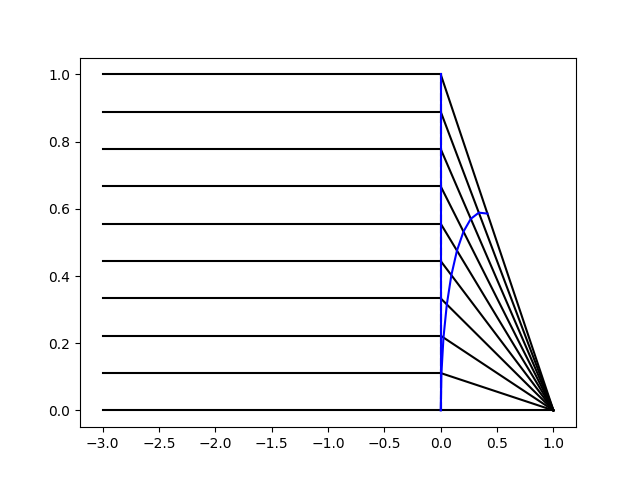

In [197]:
plt.figure()
plt.vlines(0, 0, 1, color = 'k', linestyle = '--')
plt.plot([rays_start_z, rays_lens_z], [rays_start[0, :], rays_lens[0, :]], '-k')
plt.plot([rays_lens_z, rays_focal_z], [rays_lens[0, :], rays_focal[0, :]], '-k')
plt.plot(z01_given_opl, x01_given_z, '-b')
plt.plot(z12_given_opl, x12_given_z, '-b')

z = 1.0 + np.sqrt(1.0**2 - (0 - rays_lens[0, :])**2)
x = np.sqrt(1.0**2 - (z)**2)

plt.plot(z, x)
# plt.axis('equal')

In [198]:

f = 10
N = 10
rays_start_z = np.linspace(-3, -3, N)
rays_start_x = np.linspace(0, 1, N)
rays_slope = np.linspace(0, 0, N)
rays_start = np.array([rays_start_x, rays_slope])
rays_start_opl = np.zeros(N)

lens_mat = lambda f: np.array([[1, 0], [-1 / f, 1]])
prop_mat = lambda d: np.array([[1, d], [0, 1]])

lens_z = 0.0
rays_lens_z = rays_start_z + (lens_z - rays_start_z)
lens_f = 1.0
rays_focal_z = rays_lens_z + (lens_f - rays_lens_z)

rays_lens = np.matmul(prop_mat(lens_z - rays_start_z[0]), rays_start)
rays_start_lens_opl_left = rays_start_opl + np.sqrt((lens_z - rays_start_z) ** 2 + (rays_lens[0, :] - rays_start_x) ** 2)
rays_lens = np.matmul(lens_mat(lens_f), rays_lens)

h = np.sqrt(lens_f ** 2 + rays_lens[0, :] **2) - lens_f
rays_start_lens_opl_right = rays_start_lens_opl_left - h
rays_focal = np.matmul(prop_mat(lens_f), rays_lens)
rays_lens_focal_opl = rays_start_lens_opl_right + np.sqrt((lens_f - lens_z) ** 2 + rays_focal[0, :] ** 2)

opl_value = 3

z01_given_opl, x01_given_z = interp_coordinates_from_optical_path_length(rays_start_opl, rays_start_lens_opl_left, 
                                                                        rays_start_z, rays_lens_z,
                                                                        rays_start[0, :], rays_lens[0, :],
                                                                        opl_value)
opl_value = 3.0
z12_given_opl, x12_given_z = interp_coordinates_from_optical_path_length(rays_start_lens_opl_right, rays_lens_focal_opl, 
                                                                        rays_lens_z, rays_focal_z,
                                                                        rays_lens[0, :], rays_focal[0, :],
                                                                        opl_value)